In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Завантаження набору даних IMDb Reviews з додатковою інформацією
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Виведення додаткової інформації про набір даних
print(info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6KBBLK_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6KBBLK_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6KBBLK_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmp0kisnesttfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text

In [4]:
import pandas as pd

# Используем объект info для извлечения информации о наборе данных
dataset_info = info

# Создаем словарь с извлеченной информацией
data_dict = {
    "Split": ["train", "test", "unsupervised"],
    "Number of Examples": [
        dataset_info.splits["train"].num_examples,
        dataset_info.splits["test"].num_examples,
        dataset_info.splits["unsupervised"].num_examples
    ],
    "Features": [
        dataset_info.features,
        dataset_info.features,
        dataset_info.features
    ],
    "Labels": [
        dataset_info.features["label"].names,
        dataset_info.features["label"].names,
        dataset_info.features["label"].names
    ],
    # Можно добавить другую релевантную информацию
}

# Преобразуем словарь в DataFrame для удобного отображения данных
df = pd.DataFrame(data_dict)
df


,Split,Number of Examples,Features,Labels
0,train,25000,"(text, label)","[neg, pos]"
1,test,25000,"(text, label)","[neg, pos]"
2,unsupervised,50000,"(text, label)","[neg, pos]"


In [5]:
#подивимось, що у нас в imdb
imdb

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('unsupervised'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [6]:
train_data, test_data = imdb["train"], imdb["test"]

for i in train_data.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [7]:
#Зробимо порожні списки
train_sentences = []
train_labels = []
test_sentences = []
test_labels = []

In [8]:
for s, l in train_data:
  train_sentences.append(s.numpy().decode('utf-8'))
  train_labels.append(l.numpy())

for i, text in zip(train_labels[:6], train_sentences[:6]):
  print(f'label {i}: {text[:150]}...')

label 0: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be the...
label 0: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable ...
label 0: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem...
label 1: This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chai...
label 1: As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female...
label 1: This is a film which should be seen by anybody interested in, effected by, or suffering from an eating disorder. It is an amazingly accurate and sensi...


In [9]:
for s, l in test_data:
  test_sentences.append(s.numpy().decode('utf-8'))
  test_labels.append(l.numpy())

for i, text in zip(test_labels[:6], test_sentences[:6]):
  print(f'label {i}: {text[:150]}...')


label 1: There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add...
label 1: A blackly comic tale of a down-trodden priest, Nazarin showcases the economy that Luis Bunuel was able to achieve in being able to tell a deeply human...
label 0: Scary Movie 1-4, Epic Movie, Date Movie, Meet the Spartans, Not another Teen Movie and Another Gay Movie. Making "Superhero Movie" the eleventh in a s...
label 0: Poor Shirley MacLaine tries hard to lend some gravitas to this mawkish, gag-inducing "feel-good" movie, but she's trampled by the run-away sentimental...
label 1: As a former Erasmus student I enjoyed this film very much. It was so realistic and funny. It really picked up the spirit that exists among Erasmus stu...
label 1: My God, Ryan Gosling has made a lot of deep characters in his career, this is one of his wonderful acting jobs. For me this is a very deep movie, need...


In [10]:
# Перетворимо на масив
training_labels_final = np.array(train_labels)
testing_labels_final = np.array(test_labels)

In [11]:
def plot_graphs(history, string):
  plt.figure(figsize=(5, 3))
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def report(x):
  predictions = x.predict(testing_padded)
  x.evaluate(testing_padded, testing_labels_final)
  # To get a clearer view of forecasts, it can be created in binary format:
  binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

  # Some predicted values can be displayed alongside the actual values for comparison
  for i in range(10):
      print(f"Predicted: {binary_predictions[i]}, Label: {1 if testing_labels_final[i] > 0.5 else 0}")

  report = classification_report(testing_labels_final, binary_predictions)
  print(report)


  # Compute the confusion matrix
  cm = confusion_matrix(testing_labels_final, binary_predictions)

  # Create a DataFrame to display the confusion matrix with labels
  confusion_df = pd.DataFrame(columns=["Positive", "Negative"],
                              index=["Positive", "Negative"],
                              data=cm)

  # Create a heatmap using seaborn
  f,ax = plt.subplots(figsize=(4,4))
  sns.heatmap(confusion_df, annot=True,cmap="Reds", fmt= 'd',ax=ax)
  plt.xlabel("Predicted Label")
  plt.xticks(size = 12)
  plt.yticks(size = 12, rotation = 0)
  plt.ylabel("Actual Label")
  plt.title("Confusion Matrix", size = 14)
  plt.show()

  print ("TP:" , (cm[0,0]))
  print ("TN:" , (cm[1,1]))
  print ("FP:" , (cm[0,1]))
  print ("FN:" , (cm[1,0]))

  # Display the heatmap
  plt.show()

In [12]:
vocab_size = 10000
max_length = 120
embedding_dim = 32
trunc_type = 'post'
oov_tok = ""
BATCH_SIZE=128
NUM_EPOCHS = 5

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type)


In [14]:
print(testing_padded[-1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   34   41
   90   95 2466   38   34  341    6   12   29   67 2207   85  103    3
    2  831 3144    5  542  118 2714  124 6521   16    4 7608 1070  121
   12  129 1287   15   29    5    2 4098 1147 7608 1070  285    3   29
    5    2   89    1 1574  448 8608 2127]


In [15]:
epoch_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, verbose=1, mode='auto', restore_best_weights=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Setup the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(padded, training_labels_final, epochs=NUM_EPOCHS, batch_size=128, validation_data=(testing_padded, testing_labels_final), callbacks=[reduce_lr, epoch_callback])



Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5819 - loss: 0.6748 - val_accuracy: 0.7963 - val_loss: 0.4695 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8430 - loss: 0.3876 - val_accuracy: 0.8310 - val_loss: 0.3775 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9036 - loss: 0.2600 - val_accuracy: 0.8364 - val_loss: 0.3678 - learning_rate: 0.0010
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9460 - loss: 0.1823 - val_accuracy: 0.8257 - val_loss: 0.3915 - learning_rate: 0.0010
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9719 - loss: 0.1262 - val_accuracy: 0.8248 - val_loss: 0.4028 - learning_rate: 0.0010


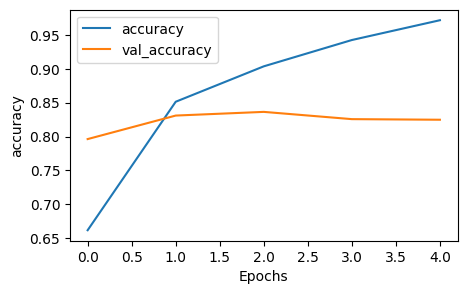

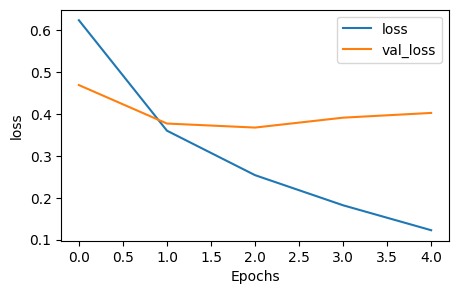

In [18]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8285 - loss: 0.3967
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     12500
           1       0.84      0.80      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



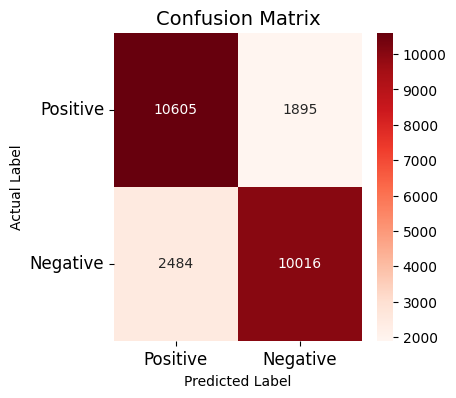

TP: 10605
TN: 10016
FP: 1895
FN: 2484


In [19]:
report(model)

LSTM

In [20]:
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(lstm_dim),
    #tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final), callbacks=[epoch_callback, reduce_lr])


Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6212 - loss: 0.6179 - val_accuracy: 0.8234 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8689 - loss: 0.3205 - val_accuracy: 0.8182 - val_loss: 0.4039 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9149 - loss: 0.2298 - val_accuracy: 0.8198 - val_loss: 0.4119 - learning_rate: 0.0010
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9379 - loss: 0.1831 - val_accuracy: 0.8247 - val_loss: 0.4431 - learning_rate: 2.0000e-04
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9497 - loss: 0.1578 - val_accuracy: 0.8222 - val_loss: 0.4468 - learning_rate: 2.0000e-04


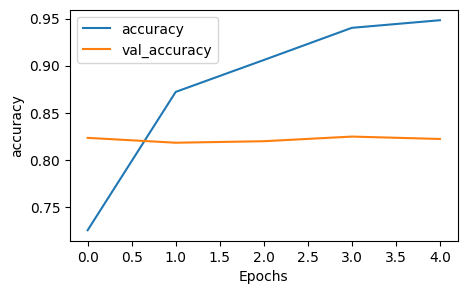

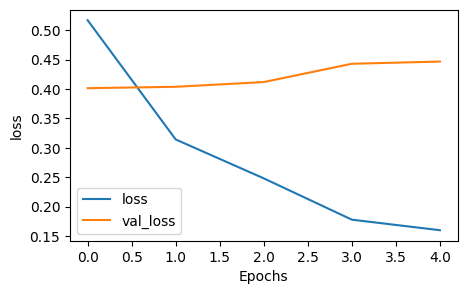

In [22]:
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8246 - loss: 0.4447
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.81      0.84      0.83     12500
           1       0.83      0.80      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



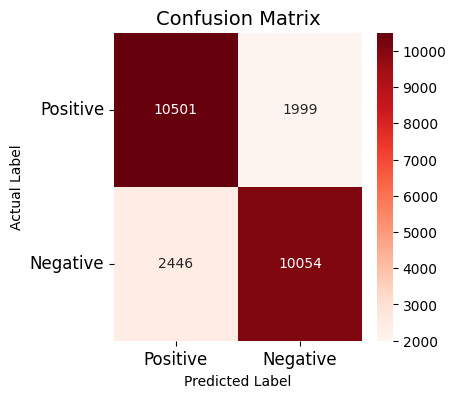

TP: 10501
TN: 10054
FP: 1999
FN: 2446


In [23]:
report(model_lstm)

RNN

In [24]:
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
history_conv = model_conv.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final), callbacks=[reduce_lr])

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6214 - loss: 0.6334 - val_accuracy: 0.8207 - val_loss: 0.3997 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8725 - loss: 0.3177 - val_accuracy: 0.8340 - val_loss: 0.3798 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9000 - loss: 0.2524 - val_accuracy: 0.8278 - val_loss: 0.4010 - learning_rate: 0.0010
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9223 - loss: 0.2099 - val_accuracy: 0.8210 - val_loss: 0.4359 - learning_rate: 0.0010
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9386 - loss: 0.1778 - val_accuracy: 0.8221 - val_loss: 0.4441 - learning_rate: 2.0000e-04


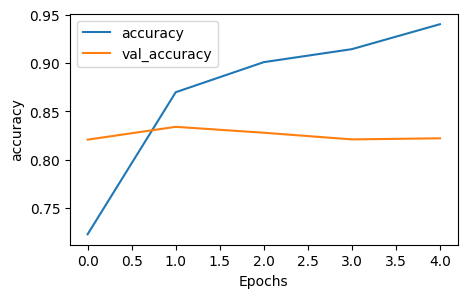

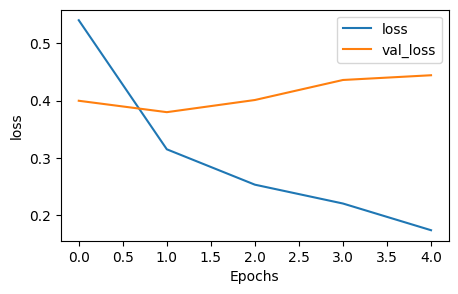

In [26]:
plot_graphs(history_conv, "accuracy")
plot_graphs(history_conv, "loss")

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8239 - loss: 0.4413
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.81      0.84      0.83     12500
           1       0.83      0.80      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



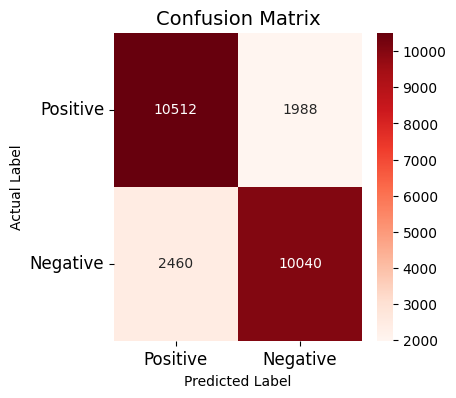

TP: 10512
TN: 10040
FP: 1988
FN: 2460


In [27]:
report(model_conv)

SRNNs

In [28]:
max_features = 20000
maxlen = 120
embedding_vector_length = 32

# Model Definition
model_srnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_srnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_srnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
history_srnn = model_srnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final),
                              callbacks=[reduce_lr, epoch_callback])

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6617 - loss: 0.5888 - val_accuracy: 0.8217 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8725 - loss: 0.3152 - val_accuracy: 0.8224 - val_loss: 0.4146 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8974 - loss: 0.2634 - val_accuracy: 0.8143 - val_loss: 0.4791 - learning_rate: 0.0010
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9198 - loss: 0.2114 - val_accuracy: 0.8016 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9521 - loss: 0.1399 - val_accuracy: 0.8164 - val_loss: 0.5665 - learning_rate: 2.0000e-04


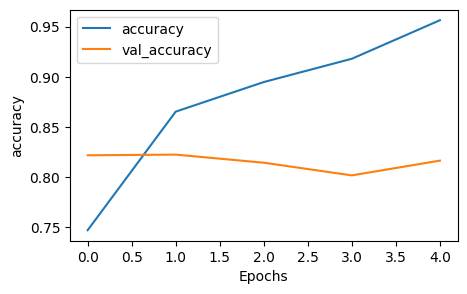

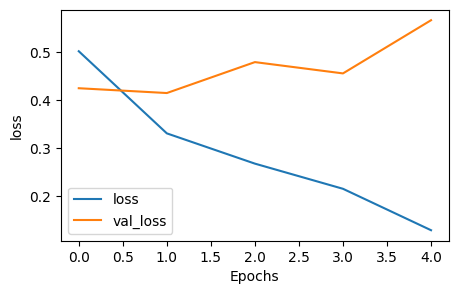

In [30]:
plot_graphs(history_srnn, "accuracy")
plot_graphs(history_srnn, "loss")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8156 - loss: 0.5655
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     12500
           1       0.82      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



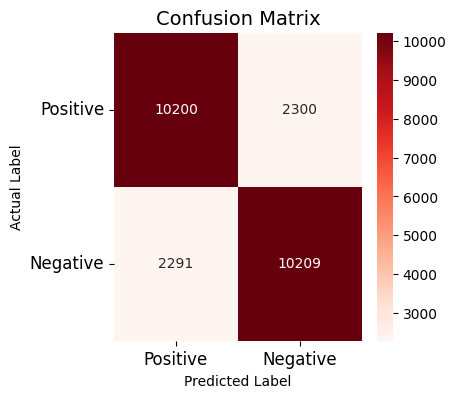

TP: 10200
TN: 10209
FP: 2300
FN: 2291


In [31]:
report(model_srnn)

BRNN

In [33]:
max_features = 20000
maxlen = 120
embedding_vector_length = 32

# Model Definition
model_brnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_brnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_brnn.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
history_brnn = model_brnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6370 - loss: 0.6005 - val_accuracy: 0.8229 - val_loss: 0.3992
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8671 - loss: 0.3228 - val_accuracy: 0.8265 - val_loss: 0.3929
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9036 - loss: 0.2481 - val_accuracy: 0.8125 - val_loss: 0.4219
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9169 - loss: 0.2211 - val_accuracy: 0.8200 - val_loss: 0.4381
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9262 - loss: 0.1987 - val_accuracy: 0.8146 - val_loss: 0.4503


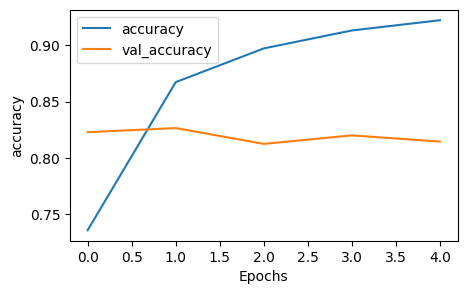

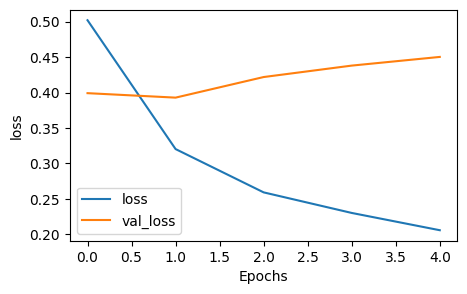

In [35]:
plot_graphs(history_brnn, "accuracy")
plot_graphs(history_brnn, "loss")

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8165 - loss: 0.4456
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.82      0.81      0.81     12500
           1       0.81      0.82      0.82     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



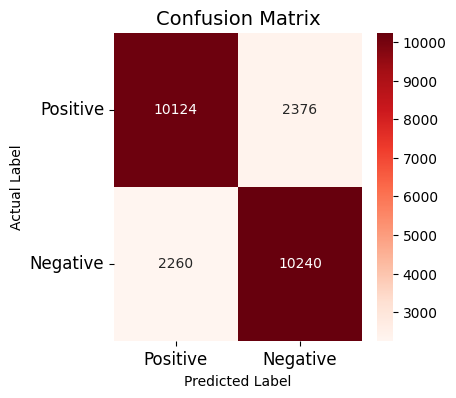

TP: 10124
TN: 10240
FP: 2376
FN: 2260


In [36]:
report(model_brnn)

Deep BRNN

In [37]:
max_features = 20000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
embedding_vector_length = 32

# Model Definition
model_dbrnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_dbrnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_dbrnn.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
history_dbrnn = model_dbrnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final), callbacks=[reduce_lr, epoch_callback])


Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.6365 - loss: 0.6025 - val_accuracy: 0.8162 - val_loss: 0.3956 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8751 - loss: 0.3036 - val_accuracy: 0.8212 - val_loss: 0.3944 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9057 - loss: 0.2469 - val_accuracy: 0.8067 - val_loss: 0.4260 - learning_rate: 0.0010
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9277 - loss: 0.1987 - val_accuracy: 0.8148 - val_loss: 0.4742 - learning_rate: 0.0010
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9573 - loss: 0.1231 - val_accuracy: 0.8120 - val_loss: 0.6104 - learning_rate: 2.0000e-04


782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8175 - loss: 0.5990
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     12500
           1       0.84      0.77      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



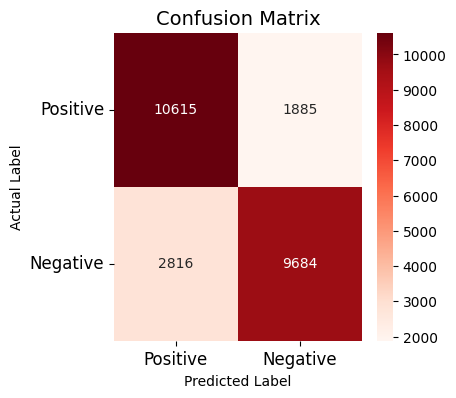

TP: 10615
TN: 9684
FP: 1885
FN: 2816


In [39]:
report(model_dbrnn)

Усі використані нейронні мережі показали досить високий і відносно рівний результат. Нейронна мережа з найменшими втратами на валідації та досить високою точністю — це Flatten. Моделі, що містять LSTM шари, продемонстрували високу точність.

Виисока точність LSTM-моделей може бути обумовлена їхньою здатністю добре працювати з послідовними даними, такими як текст або часові ряди.